### Plotting alignment data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import csv
import pandas as pd
import utils.db_utils as db
import utils.plot_utils as plot
import utils.file_utils as file

bibleType = 'en_ult'
type_ = 'kt'

In [2]:
# get alignments for tW keyterms

minAlignments = 40
remove = ['ὁ', 'τὸ', 'τὰ']
alignmentsForWord, filteredAlignmentsForWord = db.fetchAlignmentDataForTWordCached(type_, bibleType, minAlignments, remove)
print(f"Original Language Alignments: {len(filteredAlignmentsForWord)}")

Using cached Alignments
Unfiltered Alignments: 4367
Using cached Filtered Alignments
Filtered Alignments: 105
Original Language Alignments: 105


### Analysis of alignments for keyterms in the en_ult:

#### Frequency of alignments:
_***Note that each line on the graphs below represents an alignment for a specific word. For example we have separate lines for 'Θεός', 'Θεὸς', or 'Θεοῦ' even though they have the same lemma.  It made sense to group the alignments this way since aligners are likely to choose different target language words based on morphology of the word._

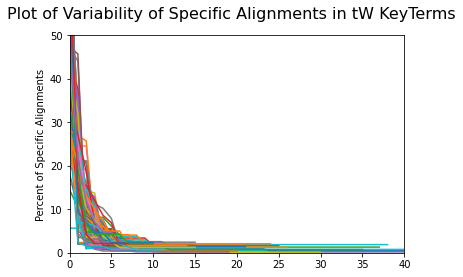

In [3]:
frequenciesOfAlignments = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, 'alignmentTxt')

title = f"Plot of Variability of Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlimit = [0, 40]
plot.plotFrequencies(frequenciesOfAlignments, title, ylabel, showXValues=False, xlimit=xlimit)

In [4]:
stats = []
for word in frequenciesOfAlignments.keys():
    frequency = frequenciesOfAlignments[word]
    alignments = filteredAlignmentsForWord[word]
    total = len(alignments)
    counts = list(frequency.values)
    ratio = list(map(lambda x: x/total, counts))
    countsSeries = frequency.describe()
    alignments = filteredAlignmentsForWord[word]
    stats.append({
        'originalWord': word,
        'alignments': alignments,
        'frequency': frequency,
        'counts': counts,
        'countsSeries': countsSeries,
        'total': total,
        'ratio': ratio
    })

path_ = './data/TrainingData/kt_en_ult_NT_alignments_stats.csv'
stats_ = pd.DataFrame(stats).drop(columns=['alignments'])
db.saveDataFrameToCSV(path_, stats_)
print('saved')

saved


### Analysis:

#### Analysis of numerical metrics:

#### Analysis of original language word count:

Found 105 original language words for tW type kt


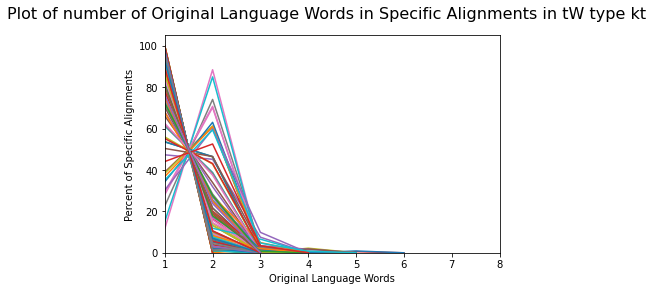

In [5]:
field = 'alignmentOrigWords'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

print(f"Found {len(field_frequencies)} original language words for tW type {type_}")
title = f"Plot of number of Original Language Words in Specific Alignments in tW type {type_}"
ylabel = "Percent of Specific Alignments"
xlabel = "Original Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[1, 8])


##### Notes:
- this field analysis suggests that original word counts are tight - a threshold word count of 3 probably good for English to flag for review.
<p></p>

Out of 105, found 3 original language words that have instances with over 4 words


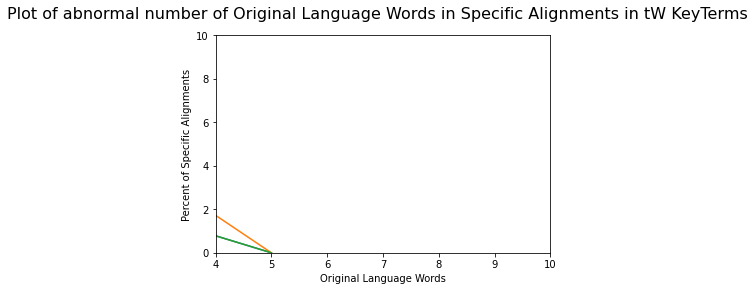

In [6]:
threshold = 4
abnormalAlignments = {}
for origWord in field_frequencies:
    frequency = field_frequencies[origWord]
    count = len(frequency)
    if count >= threshold:
        abnormalAlignments[origWord] = frequency

print(f"Out of {len(field_frequencies)}, found {len(abnormalAlignments)} original language words that have instances with over {threshold} words")
filledFrequencies = db.zeroFillFrequencies(abnormalAlignments)

title = f"Plot of abnormal number of Original Language Words in Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Original Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[threshold, 10], ylimit=[0, 10])

#### Analysis of target language word count:

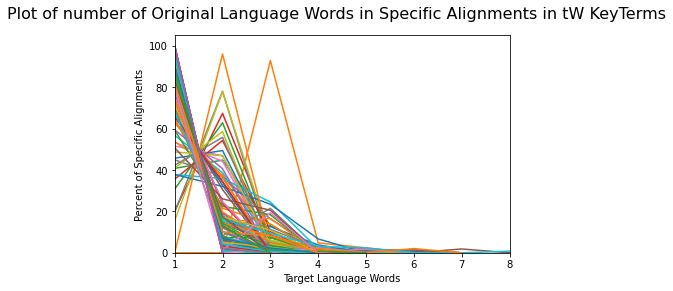

In [7]:
field = 'alignmentTargetWords'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Original Language Words in Specific Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Target Language Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[1, 8])

##### Notes:
- this field analysis suggests that a threshold word count of 3 probably good for English to flag for review.
<p></p>

#### Analysis of count of extra unaligned words between aligned original language words:

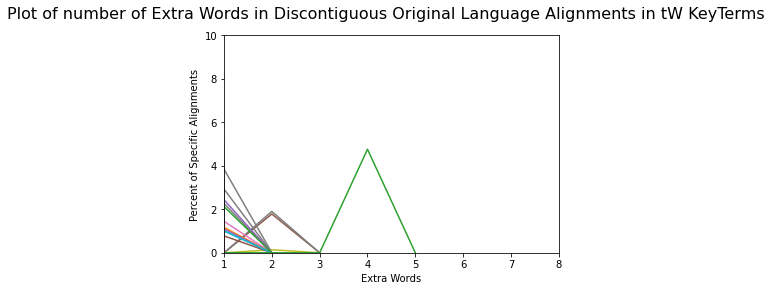

In [8]:
field = 'origWordsBetween'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Extra Words in Discontiguous Original Language Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Extra Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True, xlimit=[1, 8], ylimit=[0,10])

##### Notes:
- this field analysis suggests that most original language alignments probably good. Probably the cases of a word between aligned words should be reviewed.
<p></p>

#### Analysis of count of extra unaligned words between aligned target language words:

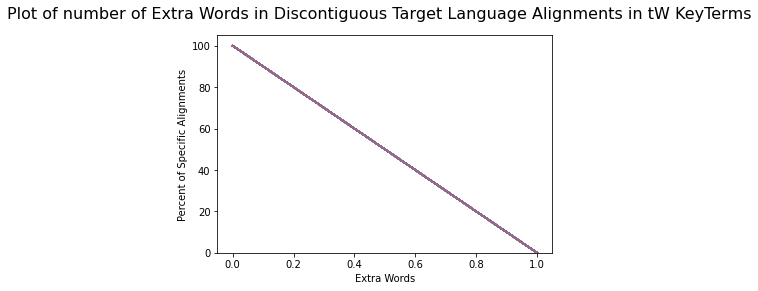

In [9]:
field = 'targetWordsBetween'
field_frequencies = db.getFrequenciesOfFieldInAlignments(filteredAlignmentsForWord, field, sortIndex = True)
filledFrequencies = db.zeroFillFrequencies(field_frequencies)

title = f"Plot of number of Extra Words in Discontiguous Target Language Alignments in tW KeyTerms"
ylabel = "Percent of Specific Alignments"
xlabel = "Extra Words"
plot.plotXYdataDict(filledFrequencies, title, ylabel, xlabel, showXValues=True)

##### Notes:
- this field analysis suggests that most target language alignments are very tight.

#### Generate CSV of questionable alignments:

In [10]:
alignmentOrigWordsThreshold = 3
alignmentTargetWordsThreshold = 5
origWordsBetweenThreshold = 1
targetWordsBetweenThreshold = 1
warningData = db.generateWarnings(type_, bibleType, filteredAlignmentsForWord, alignmentOrigWordsThreshold,
                                  alignmentTargetWordsThreshold, origWordsBetweenThreshold, targetWordsBetweenThreshold)
print(f"Found {len(warningData)} alignments to check")

Found 163 alignments to check
